<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_latent_subspaces_cell_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/PMBio/scLVM/blob/master/tutorials/tcell_demo.ipynb

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
import os
from matplotlib import cm
import h5py
import scipy as SP
import pylab as PL

In [0]:
data = os.path.join('data_Tcells_normCounts.h5f')
f = h5py.File(data,'r')
Y = f['LogNcountsMmus'][:]                 # gene expression matrix
tech_noise = f['LogVar_techMmus'][:]       # technical noise
genes_het_bool=f['genes_heterogen'][:]     # index of heterogeneous genes
geneID = f['gene_names'][:]            # gene names
cellcyclegenes_filter = SP.unique(f['cellcyclegenes_filter'][:].ravel() -1) # idx of cell cycle genes from GO
cellcyclegenes_filterCB = f['ccCBall_gene_indices'][:].ravel() -1        # idx of cell cycle genes from cycle base ...

In [0]:
# filter cell cycle genes
idx_cell_cycle = SP.union1d(cellcyclegenes_filter,cellcyclegenes_filterCB)
# determine non-zero counts
idx_nonzero = SP.nonzero((Y.mean(0)**2)>0)[0]
idx_cell_cycle_noise_filtered = SP.intersect1d(idx_cell_cycle,idx_nonzero)
# subset gene expression matrix
Ycc = Y[:,idx_cell_cycle_noise_filtered]

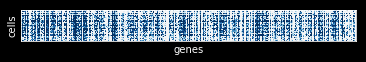

In [40]:
plt = PL.subplot(1,1,1);
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None');
#PL.colorbar();
plt.set_xticks([]);
plt.set_yticks([]);
PL.xlabel('genes');
PL.ylabel('cells');

In [0]:
X = np.delete(Y, idx_cell_cycle_noise_filtered, axis=1)
U = Y[:,idx_cell_cycle_noise_filtered]

In [0]:
mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

indx_small_mean = np.argwhere(mean < 0.00001)
X = np.delete(X, indx_small_mean, axis=1)

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

In [0]:
fano = variance/mean

In [0]:
indx_small_fano = np.argwhere(fano < 1.0)

In [135]:
X = np.delete(X, indx_small_fano, axis=1)

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

fano = variance/mean

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


In [0]:
#Reconstruction loss
def x_given_w_z(w, z, output_size):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = tf.concat((w,z), axis=-1)
    h = tf.layers.dense(h, 8, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 256, act)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for w
def w_given_x_y(x, y, latent_size): #+
  with tf.variable_scope('M/w_given_x_y'):
    act = tf.nn.leaky_relu
    h = tf.concat((x,y), axis=-1)
    
    h = tf.layers.dense(h, 256, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def w_given_y(y, y_size):
  with tf.variable_scope('M/w_given_y'):
    act = tf.nn.leaky_relu
    h = y
    
    h = tf.layers.dense(h, 256, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    return tfd.MultivariateNormalDiag(loc, scale)


#KL term for z
def z_given_x(x, latent_size): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)


#For the Mutual information term
def y_given_z(z, y_size, reuse=None):
  with tf.variable_scope('N', reuse=reuse):
    act = tf.nn.leaky_relu
    h = z
    
    h = tf.layers.dense(h, 15, act)
    h = tf.layers.dense(h, 30, act)
    h = tf.layers.dense(h, 60, act)
    h = tf.layers.dense(h, 70, act)
    h = tf.layers.dense(h, 80, act)
    
    loc = tf.layers.dense(h, y_size)
    log_variance = tf.layers.dense(h, y_size)
    scale = tf.nn.softplus(log_variance)
    #scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 887], name='u_in')


beta = np.array([1.0, 0.0001, 0.0001, 0.001, 0.001])

z_latent_size = 2
w_latent_size = 2

M_learning_rate = 5e-4
N_learning_rate = 5e-4

#KL_w
wIy = w_given_y(u_in, w_latent_size)
wIxy = w_given_x_y(x_in, u_in, w_latent_size)
wIxy_sample = wIxy.sample()
wIxy_mean = wIxy.mean()
kl_w = tf.reduce_mean(wIxy.log_prob(wIxy_sample)- wIy.log_prob(wIxy_sample))

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))

#Reconstruction
xIwz = x_given_w_z(wIxy_sample, zIx_sample, X.shape[1])
rec_out = xIwz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

M1 = beta[0]*rec_loss + beta[1]*kl_w + beta[2]*kl_z

yIz = y_given_z(zIx_sample, U.shape[1], reuse=False)
ent2 = -tf.reduce_mean(-yIz.entropy())
M2 = beta[3]*ent2

M_cost = M1 + M2

M_optimizer = tf.train.AdamOptimizer(M_learning_rate)

M_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='M/')
M_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='M/')

with tf.control_dependencies(M_update_ops):
  M_train = M_optimizer.minimize(M_cost, var_list=M_train_vars,
                                       name='train_M')

  
yIz_N = y_given_z(zIx_sample, U.shape[1], reuse=True)
logN = tf.reduce_mean(-yIz_N.log_prob(u_in))
N = beta[4]*logN

N_cost = N

N_optimizer = tf.train.AdamOptimizer(N_learning_rate)

N_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='N')
N_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='N')

with tf.control_dependencies(N_update_ops):
  N_train = N_optimizer.minimize(N_cost, var_list=N_train_vars,
                                       name='train_N')

# Saver to save session for reuse
saver = tf.train.Saver()

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [221]:
n_epochs = 5000
batch_size = X.shape[0]
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    M_loss = 0
    N_loss = 0
    rec_loss_ = 0
    kl_w_ = 0
    kl_z_ = 0
    M1_ = 0
    M2_ = 0
    ent2_ = 0
    logN_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, M_loss_, rec_loss__, kl_w__, kl_z__, M1__, ent2__, M2__= sess.run([M_train, M_cost, rec_loss, kl_w, kl_z, M1, ent2, M2], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      M_loss += M_loss_
      rec_loss_ += rec_loss__
      kl_w_ += kl_w__
      kl_z_ += kl_z__
      M1_ += M1__
      M2_ += M2__
      
      _, N_loss_, logN__= sess.run([N_train, N_cost, logN], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch})
      N_loss += N_loss_
      logN_ += logN__
      
      
    if (i+1)% 50 == 0 or i == 0:
      wIxy_mean_, zIx_mean_, rec_out_= sess.run([wIxy_mean, zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, M_loss: {1:.1f}, M1_loss: {2:.1f}, M2_loss: {3:.1f}, N_loss: {4:.2f}'.format((i+1), M_loss/(1+np.int(X.shape[0]/batch_size)), M1_/(1+np.int(X.shape[0]/batch_size)), M2_/(1+np.int(X.shape[0]/batch_size)), N_loss_/(1+np.int(X.shape[0]/batch_size))))
      print('epoch: {0}, rec_loss: {1:.3f}, kl_w: {2:.2f}, kl_z: {3:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_w_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

epoch: 1, M_loss: 2.2, M1_loss: 1.7, M2_loss: 0.5, N_loss: 2.07
epoch: 1, rec_loss: 0.474, kl_w: 0.94, kl_z: 12261.18
epoch: 50, M_loss: 0.8, M1_loss: 0.3, M2_loss: 0.6, N_loss: 1.00
epoch: 50, rec_loss: 0.248, kl_w: 4.66, kl_z: 212.49
epoch: 100, M_loss: 0.9, M1_loss: 0.3, M2_loss: 0.6, N_loss: 0.58
epoch: 100, rec_loss: 0.247, kl_w: 3.15, kl_z: 41.11
epoch: 150, M_loss: 0.8, M1_loss: 0.2, M2_loss: 0.6, N_loss: 0.55
epoch: 150, rec_loss: 0.246, kl_w: 1.87, kl_z: 23.81
epoch: 200, M_loss: 0.8, M1_loss: 0.2, M2_loss: 0.6, N_loss: 0.54
epoch: 200, rec_loss: 0.237, kl_w: 4.59, kl_z: 22.06
epoch: 250, M_loss: 0.8, M1_loss: 0.2, M2_loss: 0.5, N_loss: 0.53
epoch: 250, rec_loss: 0.230, kl_w: 2.88, kl_z: 9.86
epoch: 300, M_loss: 0.8, M1_loss: 0.2, M2_loss: 0.5, N_loss: 0.53
epoch: 300, rec_loss: 0.224, kl_w: 3.37, kl_z: 15.70
epoch: 350, M_loss: 0.7, M1_loss: 0.2, M2_loss: 0.5, N_loss: 0.53
epoch: 350, rec_loss: 0.218, kl_w: 3.65, kl_z: 10.56
epoch: 400, M_loss: 0.7, M1_loss: 0.2, M2_loss: 0.5

In [217]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(U.T)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  

U_ = svd.components_

U_ = U_.T

[0.55983905 0.04389005]
0.6037290921647739
[482.32958745  71.86901165]


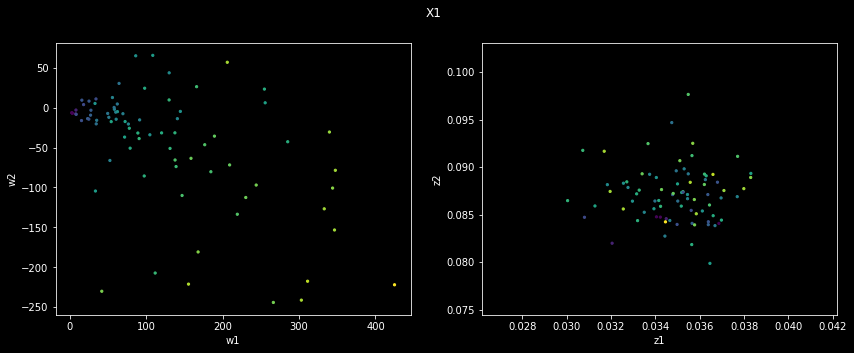

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U_[:,0], cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,0], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('X1')
plt.show()

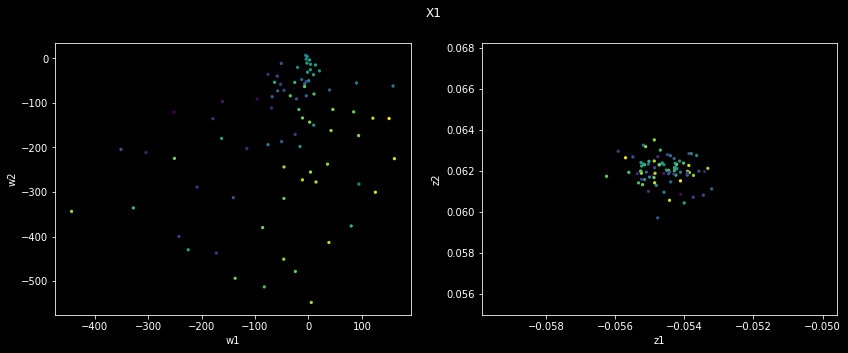

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('X1')
plt.show()

In [0]:
error = np.abs(X-rec_out_)

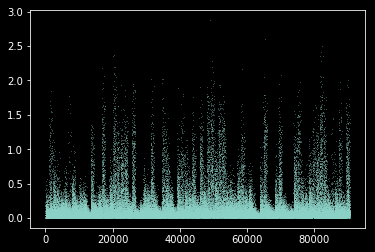

In [193]:
plt.plot(np.reshape(error, -1), '*', markersize=0.1);

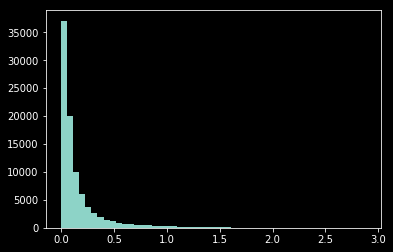

In [194]:
plt.hist(np.reshape(error, -1), bins=50);